# Mill Exploratory Data Analysis

My primary deck at the moment, and inspiration for this project, is the Mill. While most decks seek to win by setting the opponent's life total to 0 from the starting value of 20, Mill seeks to remove all of the cards in a player's library by putting putting them in the graveyard (or exiling them) and then winning by rule 121.4, which states that *"A player who attempts to draw a card from a library with no cards in it loses the game the next time a player would receive priority."* I will be focusing on the modern format for this notebook.

## Import Libraries

In [1]:
%matplotlib inline

import os
import math

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

## Import Datasets

The needed datasets might change depending on the cards and lines that need testing.

In [2]:
DIR_PATH_CARDS = os.path.join(os.getcwd(), "data", "clean_data")
DIR_PATH_DECKS = os.path.join(os.getcwd(), "data", "tournament_deck_lists")

In [3]:
Cards = pd.read_csv(os.path.join(DIR_PATH_CARDS, "Cards.csv"))
CardsCost = pd.read_csv(os.path.join(DIR_PATH_CARDS, "CardsCost.csv"))
CardsLegality = pd.read_csv(os.path.join(DIR_PATH_CARDS, "CardsLegality.csv"))
CardsPrintings = pd.read_csv(os.path.join(DIR_PATH_CARDS, "CardsPrintings.csv"))
CardsTypes = pd.read_csv(os.path.join(DIR_PATH_CARDS, "CardsTypes.csv"))

In [4]:
Mainboard = pd.read_csv(os.path.join(DIR_PATH_DECKS, "Mainboard.csv"))
Mainboard = Mainboard.loc[:, ~Mainboard.columns.str.contains('^Unnamed')]

Sideboard = pd.read_csv(os.path.join(DIR_PATH_DECKS, "Sideboard.csv"))
Sideboard = Sideboard.loc[:, ~Sideboard.columns.str.contains('^Unnamed')]

# Card Testing

Specific cards that need testing are as follows:

* **Tasha's Hideous Laughter**: This card exiles cards from the top of each opponent's library depending on the converted mana cost (cmc) of exiled cards. A very common card in Modern Mill decks.
* **Sanity Grinding**: This card depends on the number of Blue mana symbols on cards of your library. While not commonly played, there are enough blue value cards in the deck to give this card a look.
* **Mind Funeral**: This card mills cards until a 4 land cards are removed from the target player's library. This card is not commonly played and I do not expect great value on this, but I still believe that it is worth a look.
* **Hedron Crab** and **Ruin Crab**: These two cards are functionally the same and provide value over time, and I believe it would be a good idea to understand the value of these *Creature* cards over time.

I also want to take a look at expected mill value per 1 cmc in the deck. While one would expect it to be okay for one card costing half of another to mill exactly half, there is a balance that needs to be struck. If a card costs too much, it could be too slow for this deck to operate competitively, but if two cards need to be cast to match the value of a single card, you are more likely to deplete your hand due to there being less value per card.

However, the important part of these calculations is using tournament decks to determine worth, considering these are widely held as the top constructions of the top decks, especially so since I am only grabbing the top 8 decks from each tournament.

In [61]:
CardsPrintings[CardsPrintings.name == "Fractured Sanity"]["image_url"].values

array(['http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=567539&type=card',
       'http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=522120&type=card',
       'http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=526704&type=card',
       nan], dtype=object)

# Tasha's Hideous Laughter

![Each opponent exiles cards from the top of their library until that player has exiled cards with total mana value 20 or more.](http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=527365&type=card)
![Fractured Sanity](http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=567539&type=card)

This card is a gambler's dream, considering this card can either have great or poor value. At three mana to cast, the closest comparison to this card is Fractured Sanity, a card which mills 14 cards for the same converted mana cost. The added benefot from Tasha's is that it exiles the milled cards rather than putting them into the graveyard, thus helping the deck against "shuffle" effects which return a graveyard to the owner's library. However, Fractured Sanity has a "Cycle" effect, which allows the player to draw a card in its place, thus giving the player a chance to replace the card with a card that might be more useful in the moment.

As a result, it is desired to see Tasha's milling approximately the same number of cards as Fractured Sanity on average.

## Method

First, each deck will be grouped along with what cards appear on tournament lists. The number of each card played will be averaged out, returning a fully representative version of the deck. Crucial cards in the deck should be maintained as 4-ofs, which is the maximum number of a card that can be put in a deck with a few exceptions. All other cards (which hold places in the deck card "flex spots") will recieve partial representation, holding the chance of the card appearing. While not perfectly representing the deck, this should account for random decks appearing of the deck type. Information gained during the match, should largely determine sideboarding along with the "Overall" graph below.

Second, each card that is present in at least one version of the deck will multiplied by its Converted Mana Cost (cmc), which is the total mana value of the card. This will allow the average mana cost of the card to found and applied. On average, this value will be representative of one card in the deck, and thus the number of times this value goes into 20, should be the average milled cards by Tasha's Hideous Laughter.

Third, the maximum and minimum cards able be milled will be found. This will be done by taking the 0 mana value cards out of the deck. This value will be added on top of the average remaining cmc (subtracting 3 from this value to represent the opponent playing three lands) to represent the maximum cards milled, while the average remaining cmc will be used on its own to represent the minimum number of milled cards.

### Find the Mean

In [5]:
Mainboard.fillna(0, inplace=True)
Sideboard.fillna(0, inplace=True)

In [6]:
# All Dataframes should have the same number of decktypes and can be pulled from a single column list
deck_types = list(Sideboard['name'].unique())

In [7]:
# The mean of each card in each deck's mainboard
MainboardMean = Mainboard.loc[:, ~Mainboard.columns.isin(['archetype', 'url'])].groupby('name').mean()

In [8]:
# Average deck size according to taken mean of each card's prevalence
mainboard_deck_size = {}
for deck in deck_types:
    mainboard_deck_size[deck] = MainboardMean.loc[deck, MainboardMean.sum(axis=0) != 0].dropna().sum()

In [9]:
# Remove companion cards from sideboard, because they do not make it into the player's library
sideboard_columns_kept = list(Sideboard.select_dtypes(include=np.number).columns)
sideboard_columns_kept.append('name')

# The mean of each card in each deck's sideboard
SideboardMean = Sideboard.loc[:, Sideboard.columns.isin(sideboard_columns_kept)].groupby('name').mean()

In [10]:
# Average side board size according to taken mean of each card's prevalence
sideboard_deck_size = {}
for deck in deck_types:
    sideboard_deck_size[deck] = SideboardMean.loc[deck, SideboardMean.sum(axis=0) != 0].dropna().sum()

In [11]:
# Combining Sideboard and Mainboard Piles (a common strategy is to not remain at a 60 card deck when sideboarding against mill)
overall_columns_kept = list(Mainboard.select_dtypes(include=np.number).columns)
for card in list(Sideboard.select_dtypes(include=np.number).columns):
    overall_columns_kept.append(card)
sum_cards = {'name': 'first', 'archetype': 'first'}
for card in set(overall_columns_kept):
    sum_cards[card] = 'sum'
overall_columns_kept.append('name')

Overall = pd.concat([Mainboard, Sideboard]).groupby('url').agg(sum_cards).reset_index()

# The mean of each card in each deck's overall deck list
OverallMean = Overall.loc[:, Overall.columns.isin(overall_columns_kept)].groupby('name').mean()

In [12]:
# Average overall card count according to taken mean of each card's prevalence
overall_deck_size = {}
for deck in deck_types:
    overall_deck_size[deck] = OverallMean.loc[deck, OverallMean.sum(axis=0) != 0].dropna().sum()

### Apply the CMC for Each Card

In [13]:
# Reduced dataframe for speed
CardCMC = Cards[['name', 'cmc']]

In [14]:
leftover_cmc = {"Tishana's Tidebinder": 3, "Lůrien Revealed": 5, "L¾rien Revealed": 5, "Not Dead After All": 1, "Molten Collapse": 2, "Inti, Seneschal of the Sun": 2, 
                "Stalactite Stalker": 1, "Echoing Deeps": 0, "Agatha's Soul Cauldron": 2, "Bitter Triumph": 2, "Questing Druid": 2, "Deeproot Pilgrimage": 2, "Get Lost": 2,
                "Souls of the Lost": 2, "Sunken Citadel": 0, "Volatile Fault": 0, "Sleep-Cursed Faerie": 1, "Troll of Khazad-dűm": 6, "Amalia Benavides Aguirre": 2,
                "Cenote Scout": 1, "Experimental Confectioner": 3, "Spelunking": 3, "Brackish Blunder": 2, "Confounding Riddle": 3, "Expel the Interlopers": 5,
                "Tithing Blade": 2, "Trumpeting Carnosaur": 6 , "The End": 4, "Kutzil, Malamet Exemplar": 3 , "Itzquinth, Firstborn of Gishath": 2}

In [15]:
# Applies the cmc value to the prevalence of each card to appropriately calculate the cmc contribution
mainboard_mean_cmc = []
sideboard_mean_cmc = []
overall_mean_cmc = []

for deck in deck_types:
    mainboard_temp = MainboardMean.loc[deck].dropna(axis=0)
    sideboard_temp = SideboardMean.loc[deck].dropna(axis=0)
    overall_temp = OverallMean.loc[deck].dropna(axis=0)

    missing_cards = []

    for card in list(mainboard_temp.index):
        # Handle split cards
        if "/" in card:
            card_alt = card.split(" / ")[0].strip(" ")
            card_printings_cmcs = CardCMC[CardCMC.name==card_alt]['cmc'].values
        else:
            card_printings_cmcs = CardCMC[CardCMC.name==card]['cmc'].values
        # Handle cards in Cards database
        if len(card_printings_cmcs) > 0:
            cmc = card_printings_cmcs[0]
            mainboard_temp[card] = mainboard_temp[card] * cmc
            leftover_cmc[card] = cmc
        # Handle cards not in Cards database due to error or outdated source API
        else:
            if card in list(leftover_cmc.keys()):
                cmc = leftover_cmc[card]
                mainboard_temp[card] = mainboard_temp[card] * cmc
            else:
                missing_cards.append(card)
    for card in list(sideboard_temp.index):
        # If already seen, check use the saved value for speed
        if card in list(leftover_cmc.keys()):
            cmc = leftover_cmc[card]
            sideboard_temp[card] = sideboard_temp[card] * cmc
        else:
            # Handle split cards
            if "/" in card:
                card_alt = card.split("/")[0].strip(" ")
                card_printings_cmcs = CardCMC[CardCMC.name==card_alt]['cmc'].values
            else:
                card_printings_cmcs = CardCMC[CardCMC.name==card]['cmc'].values
            # Handle cards in Cards database
            if len(card_printings_cmcs) > 0:
                cmc = card_printings_cmcs[0]
                sideboard_temp[card] = sideboard_temp[card] * cmc
                leftover_cmc[card] = cmc
            else:
                missing_cards.append(card)
    for card in list(overall_temp.index):
        # All cards should be stored in leftover_cmc
        if card in list(leftover_cmc.keys()):
            overall_temp[card] = overall_temp[card] * leftover_cmc[card]
        else:
                missing_cards.append(card)

    mainboard_mean_cmc.append(mainboard_temp)
    sideboard_mean_cmc.append(sideboard_temp)
    overall_mean_cmc.append(overall_temp)

print(set(missing_cards))


set()


### Find the Maximum and the Minimum

In [16]:
mainboard_maximum = {}
mainboard_minimum = {}

for deck in deck_types:
    mainboard_temp = MainboardMean.loc[deck].dropna(axis=0)

    nonzero_cmc_count = 0
    card_count = 0
    for card in mainboard_temp.index:
        if leftover_cmc[card] != 0:
            nonzero_cmc_count += mainboard_temp[card] * leftover_cmc[card]
            card_count += mainboard_temp[card]

    mainboard_maximum[deck] = 0.95 * (20 / (nonzero_cmc_count / card_count) + (mainboard_deck_size[deck] - card_count - 5))
    mainboard_minimum[deck] = 1.05 * 20 / (nonzero_cmc_count / card_count)


In [17]:
overall_maximum = {}
overall_minimum = {}

for deck in deck_types:
    overall_temp = OverallMean.loc[deck].dropna(axis=0)

    nonzero_cmc_count = 0
    card_count = 0
    for card in overall_temp.index:
        if leftover_cmc[card] != 0:
            nonzero_cmc_count += overall_temp[card] * leftover_cmc[card]
            card_count += overall_temp[card]

    overall_maximum[deck] = 0.95 * (20 / (nonzero_cmc_count / card_count) + (overall_deck_size[deck] - card_count - 5))
    overall_minimum[deck] = 1.05 * 20 / (nonzero_cmc_count / card_count)

### Find the Average Number of Cards Milled

In [18]:
# Average cmc per card in each library state
mainboard_avg_cards = []
sideboard_avg_cards = []
overall_avg_cards = []

for i in range(len(deck_types)):
    deck = deck_types[i]
    mainboard_count = mainboard_deck_size[deck]
    sideboard_count = sideboard_deck_size[deck]
    overall_count = overall_deck_size[deck]

    mainboard_avg_cards.append(20/(mainboard_mean_cmc[i].sum()/mainboard_count))
    sideboard_avg_cards.append(20/(sideboard_mean_cmc[i].sum()/sideboard_count))
    overall_avg_cards.append(20/(overall_mean_cmc[i].sum()/overall_count))

In [19]:
# The number of different cards that are in each deck
mainboard_count_cards = [MainboardMean.loc[deck].dropna(axis=0).count() for deck in deck_types]
sideboard_count_cards = [SideboardMean.loc[deck].dropna(axis=0).count() for deck in deck_types]
overall_count_cards = [OverallMean.loc[deck].dropna(axis=0).dropna(axis=0).count() for deck in deck_types]

In [30]:
# Order lists
deck_types, mainboard_avg_cards, sideboard_avg_cards, overall_avg_cards = zip(*sorted(zip(deck_types, mainboard_avg_cards, sideboard_avg_cards, overall_avg_cards), key=(lambda x: x[1])))

In [21]:
# Average Tasha's value
avg_mainboard_value = sum(mainboard_avg_cards) / len(mainboard_avg_cards)
avg_sideboard_value = sum(sideboard_avg_cards) / len(sideboard_avg_cards)
avg_overall_value = sum(overall_avg_cards) / len(overall_avg_cards)

### Plot Value of Tasha's Hideous Laughter

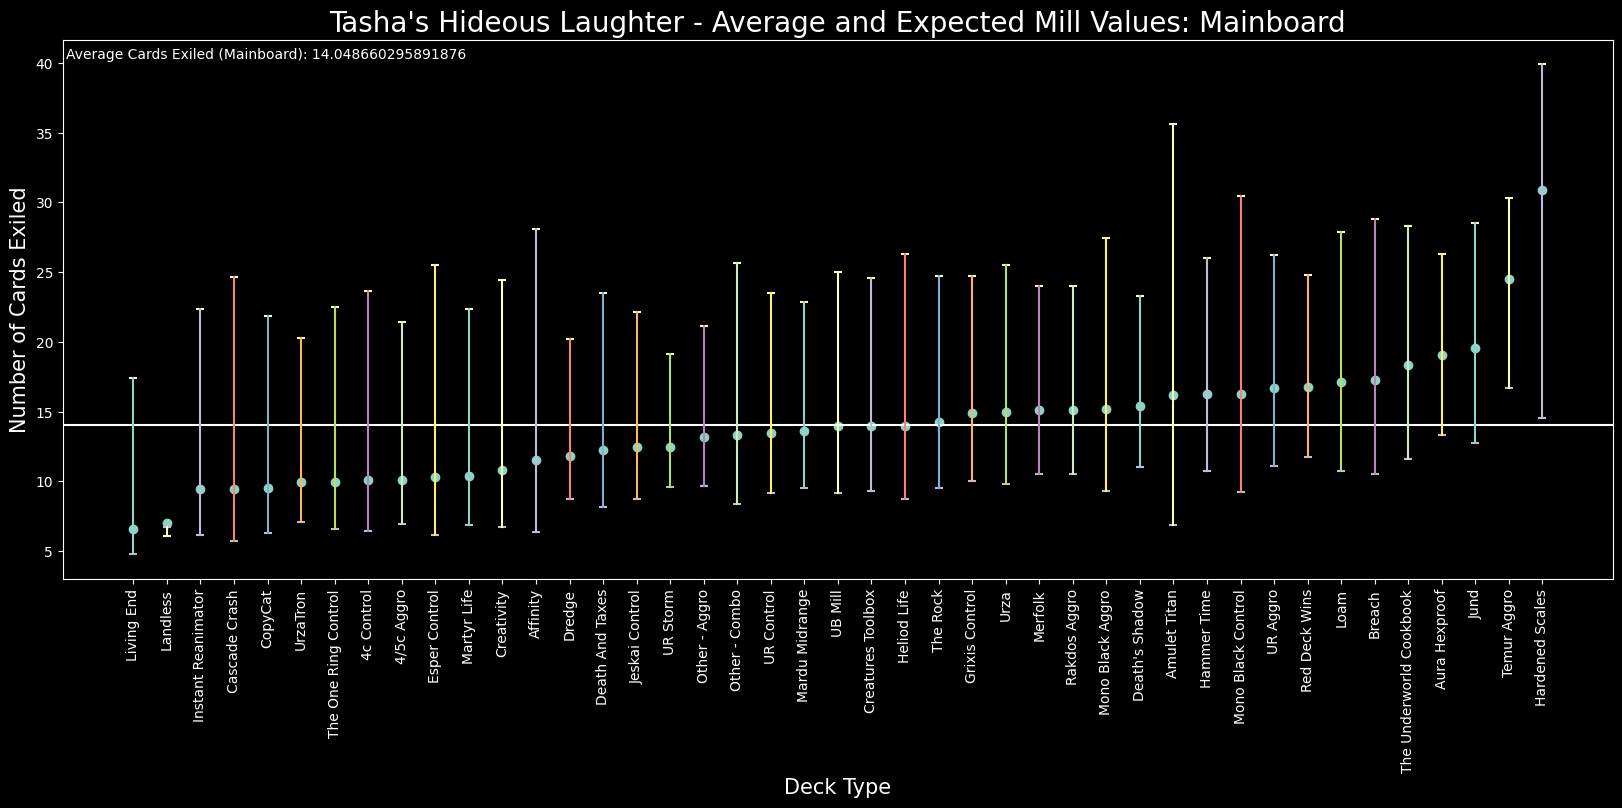

In [561]:
plt.style.use('dark_background')  # I find the dark background to be easier on the eyes
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)

ax.scatter(x=deck_types, y=mainboard_avg_cards) # Average Tasha's value
ax.scatter(x=deck_types, y=[mainboard_maximum[deck] for deck in deck_types], marker="_") # Maximum Tasha's Value
ax.scatter(x=deck_types, y=[mainboard_minimum[deck] for deck in deck_types], marker="_") # Minimum Tasha's Value

plt.title("Tasha's Hideous Laughter - Average and Expected Mill Values: Mainboard", fontsize=20)

plt.xlabel("Deck Type", fontsize=15)
plt.xticks(rotation=90)

plt.ylabel("Number of Cards Exiled", fontsize=15)
plt.yticks([0,5,10,15,20,25,30,35, 40])

# Average Value 
plt.axhline(y=avg_mainboard_value)
# Connect minimum and maximum hits
for deck in deck_types:
    ax.plot([deck, deck], [mainboard_minimum[deck], mainboard_maximum[deck]])

plt.text(x=-2, y=40.3, s=f"Average Cards Exiled (Mainboard): {avg_mainboard_value}")

plt.show()

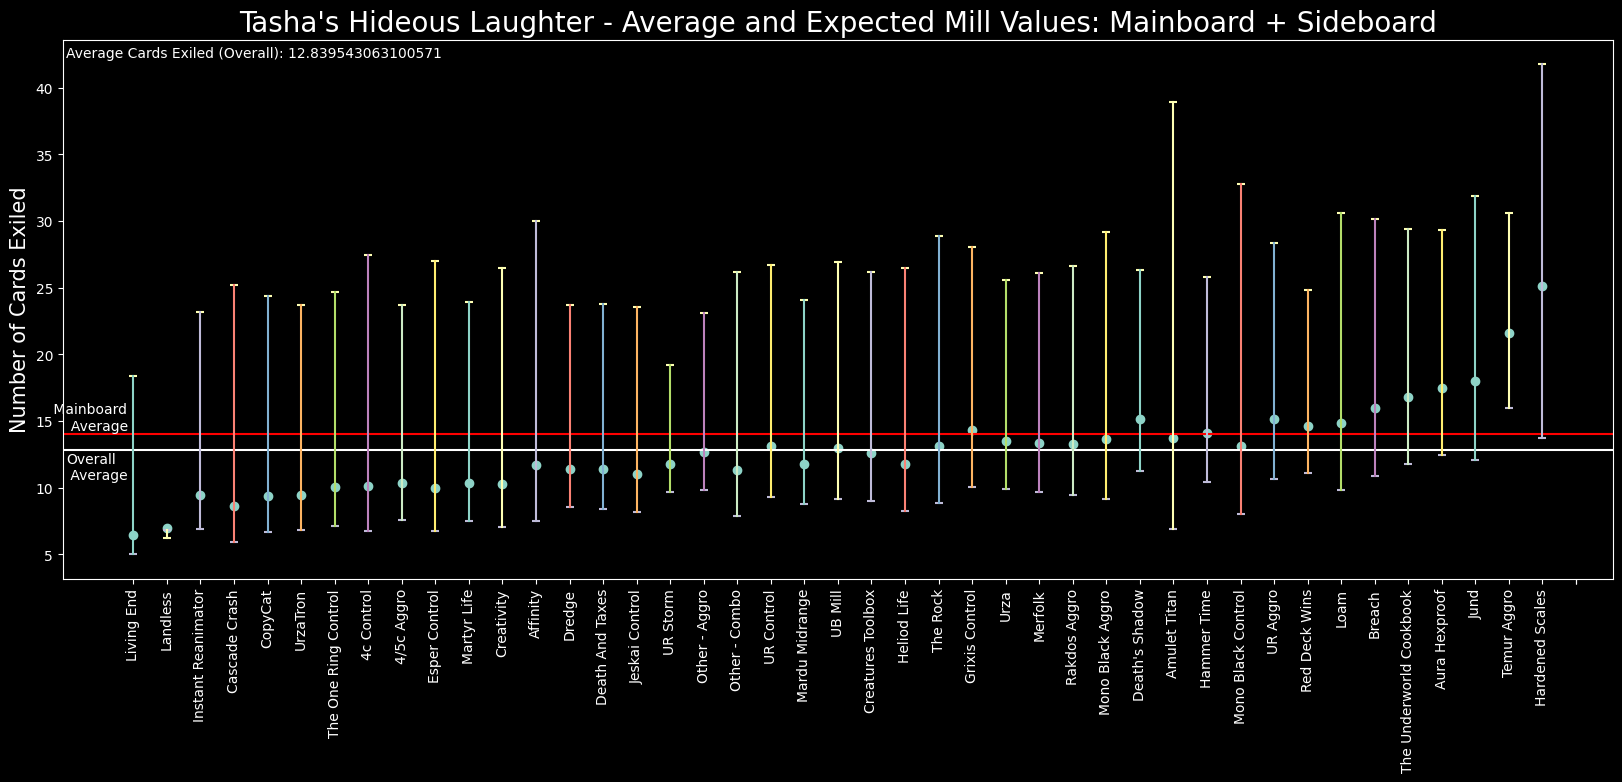

In [54]:
plt.style.use('dark_background')  # I find the dark background to be easier on the eyes
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)

ax.scatter(x=deck_types, y=overall_avg_cards) # Average Tasha's value
ax.scatter(x=deck_types, y=[overall_maximum[deck] for deck in deck_types], marker="_") # Maximum Tasha's Value
ax.scatter(x=deck_types, y=[overall_minimum[deck] for deck in deck_types], marker="_") # Minimum Tasha's Value

plt.title("Tasha's Hideous Laughter - Average and Expected Mill Values: Mainboard + Sideboard", fontsize=20)

plt.xticks(x_ticks, rotation=90)

plt.ylabel("Number of Cards Exiled", fontsize=15)
plt.yticks([0,5,10,15,20,25,30,35, 40])

# Average Value 
plt.axhline(y=avg_overall_value)
plt.axhline(y=avg_mainboard_value, color="r")
# Connect minimum and maximum hits
for deck in deck_types:
    ax.plot([deck, deck], [overall_minimum[deck], overall_maximum[deck]])

plt.text(x=-2, y=42.3, s=f"Average Cards Exiled (Overall): {avg_overall_value}")
plt.text(x=-2.5, y=avg_mainboard_value + 0.3, s=" Mainboard \n     Average")
plt.text(x=-2, y=avg_overall_value-2.2, s="Overall\n Average")

plt.show()

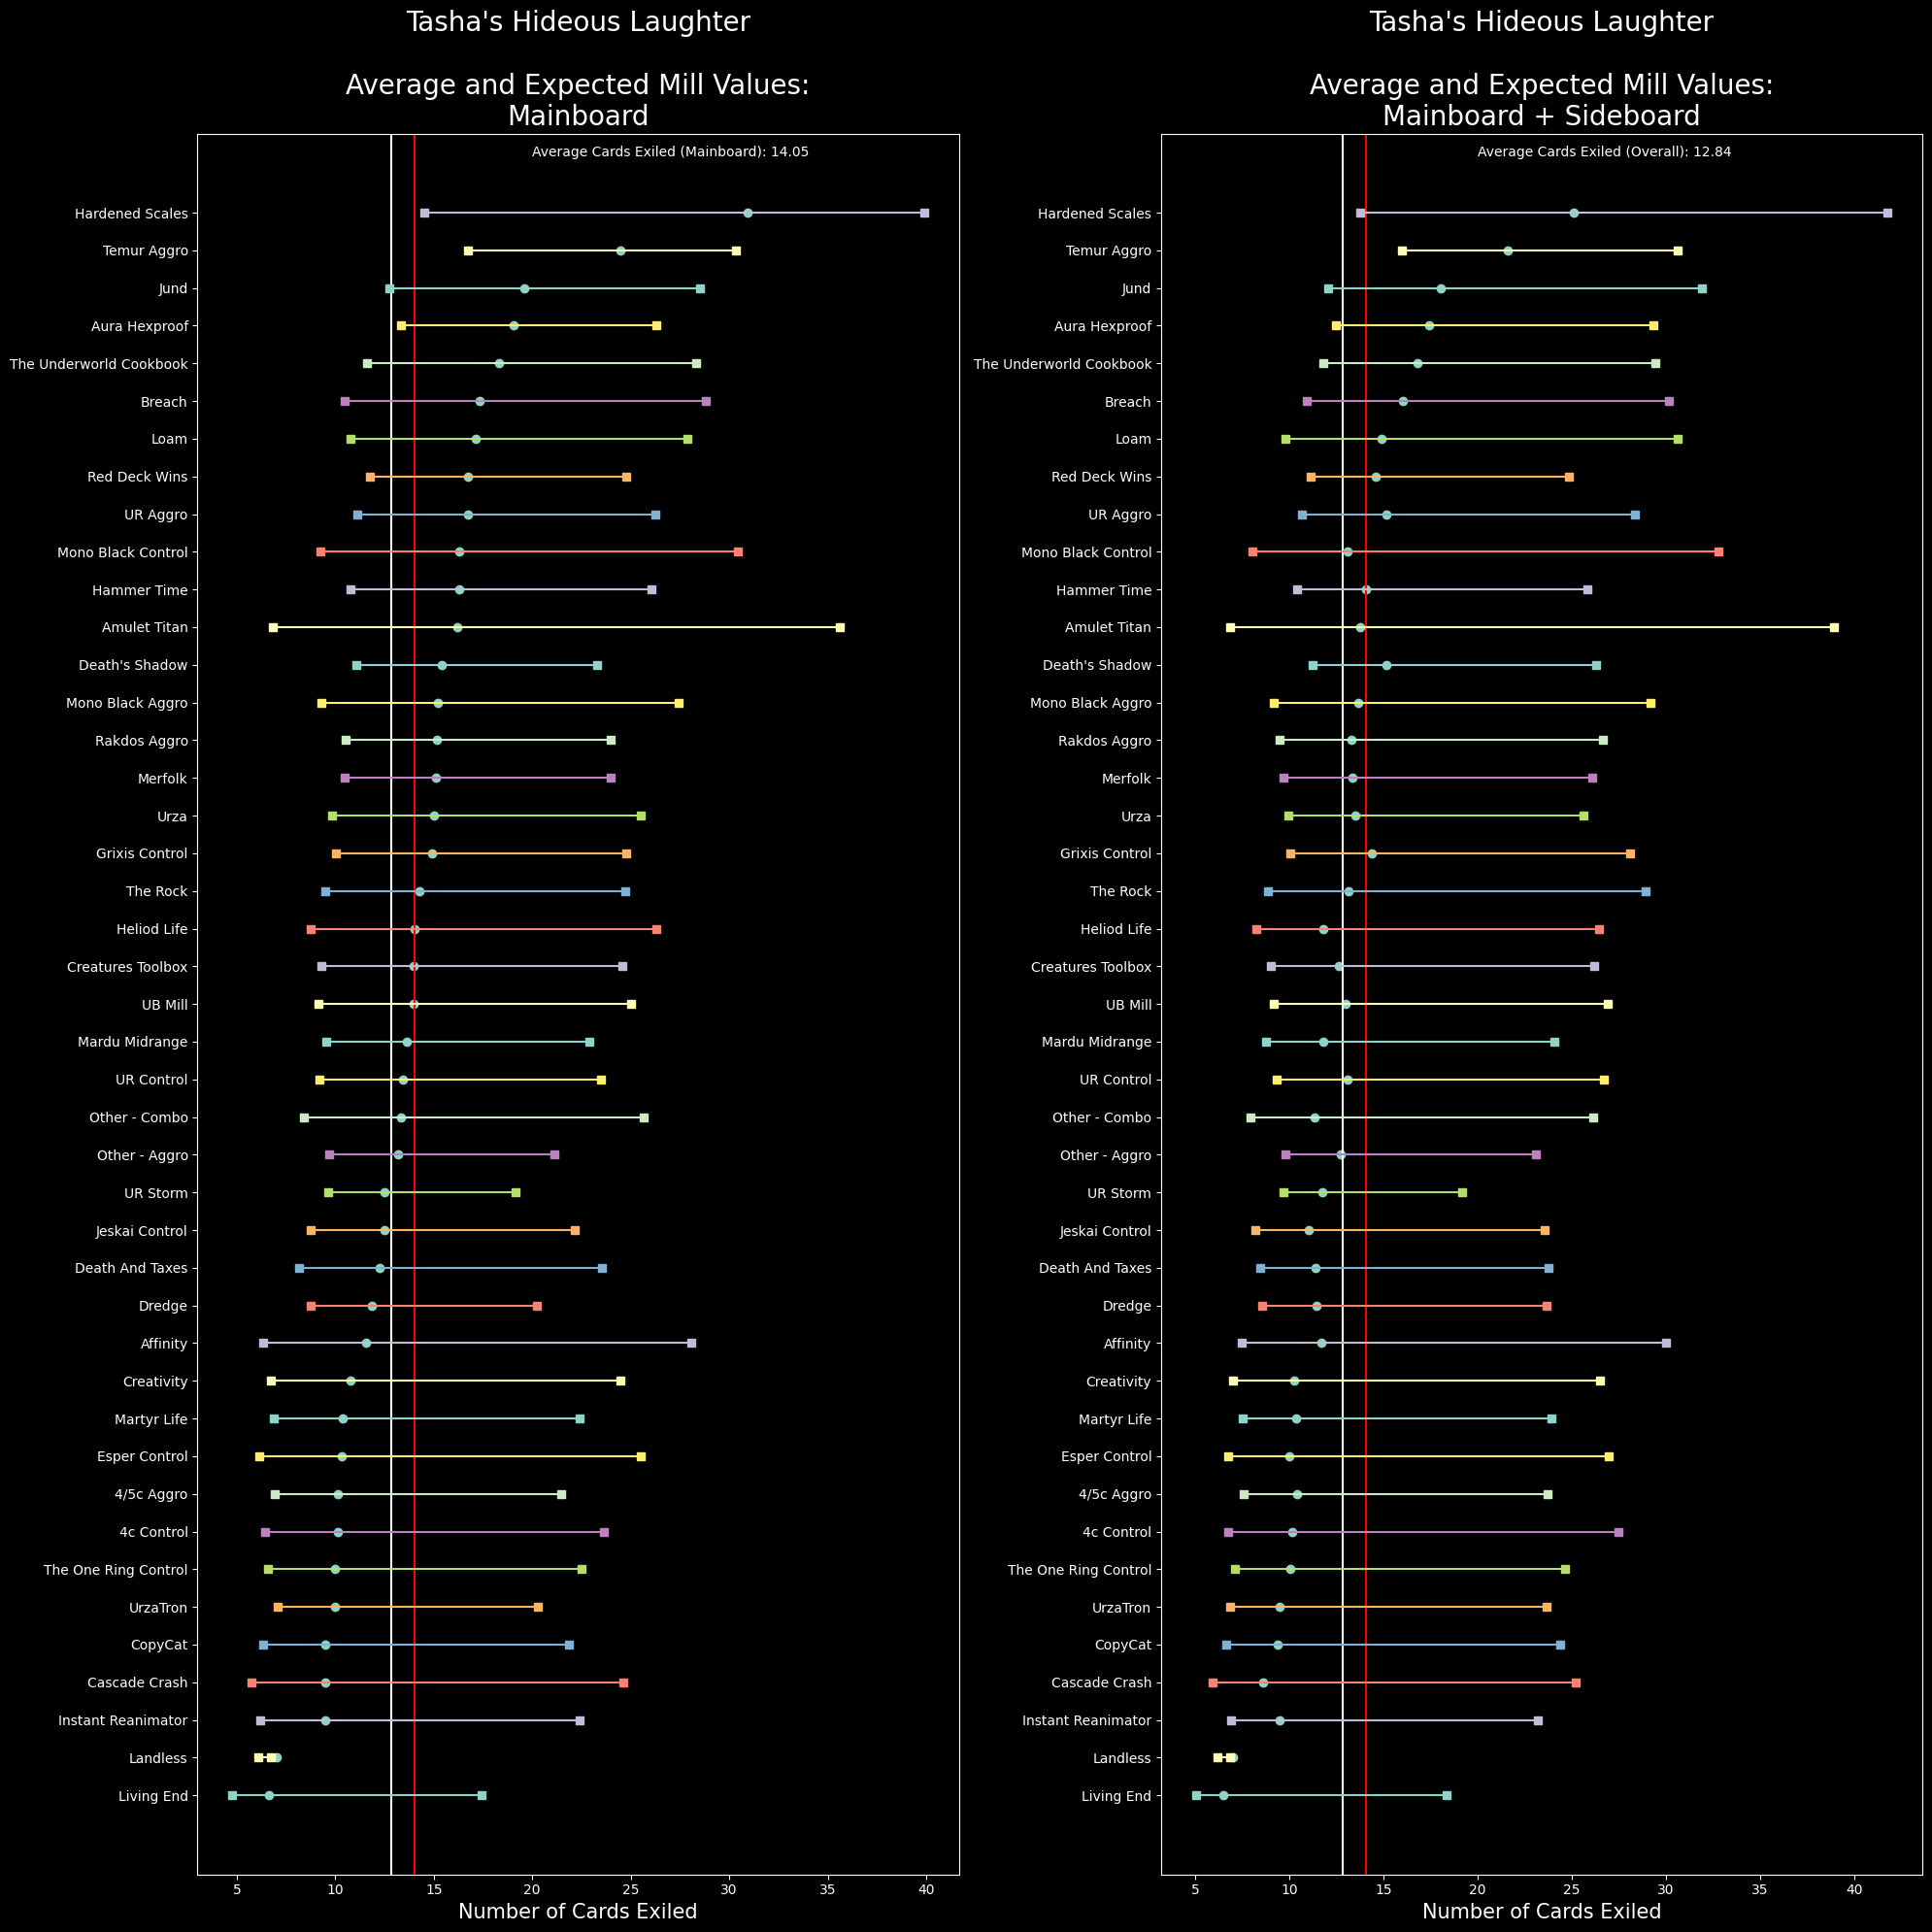

In [97]:
plt.style.use('dark_background')  # I find the dark background to be easier on the eyes
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(121)

ax1.scatter(y=deck_types, x=mainboard_avg_cards) # Average Tasha's value
ax1.scatter(y=deck_types, x=[mainboard_maximum[deck] for deck in deck_types], marker="_") # Maximum Tasha's Value
ax1.scatter(y=deck_types, x=[mainboard_minimum[deck] for deck in deck_types], marker="_") # Minimum Tasha's Value

plt.title("Tasha's Hideous Laughter\n\nAverage and Expected Mill Values:\nMainboard", fontsize=20)

plt.yticks(deck_types)

plt.xlabel("Number of Cards Exiled", fontsize=15)
plt.xticks([0,5,10,15,20,25,30,35, 40])

# Average Value 
plt.axvline(avg_overall_value)
plt.axvline(x=avg_mainboard_value, color="r")
# Connect minimum and maximum hits
for deck in deck_types:
    ax1.plot([mainboard_minimum[deck], mainboard_maximum[deck]], [deck, deck], marker="s")

plt.text(x=20, y=43.5, s=f"Average Cards Exiled (Mainboard): {round(avg_mainboard_value, 2)}")
#plt.text(x=-2.5, y=avg_mainboard_value + 0.3, s=" Mainboard \n     Average")
#plt.text(x=-2, y=avg_mainboard_value-2.2, s="Overall\n Average")

"""
    Below is the plot for overall vertical plot
"""

ax2 = fig.add_subplot(122)

ax2.scatter(y=deck_types, x=overall_avg_cards) # Average Tasha's value
ax2.scatter(y=deck_types, x=[overall_maximum[deck] for deck in deck_types], marker="_") # Maximum Tasha's Value
ax2.scatter(y=deck_types, x=[overall_minimum[deck] for deck in deck_types], marker="_") # Minimum Tasha's Value

plt.title("Tasha's Hideous Laughter\n\nAverage and Expected Mill Values:\nMainboard + Sideboard", fontsize=20)

plt.yticks(deck_types)

plt.xlabel("Number of Cards Exiled", fontsize=15)
plt.xticks([0,5,10,15,20,25,30,35, 40])

# Average Value 
plt.axvline(avg_overall_value)
plt.axvline(x=avg_mainboard_value, color="r")
# Connect minimum and maximum hits
for deck in deck_types:
    ax2.plot([overall_minimum[deck], overall_maximum[deck]], [deck, deck], marker="s")

plt.text(x=20, y=43.5, s=f"Average Cards Exiled (Overall): {round(avg_overall_value, 2)}")
#plt.text(x=-2.5, y=avg_mainboard_value + 0.3, s=" Mainboard \n     Average")
#plt.text(x=-2, y=avg_overall_value-2.2, s="Overall\n Average")

fig.tight_layout()
plt.show()

## Conclusions

On average, Tasha's performs similarly to Fractured Sanity in the first game of the match, with an expected level of variance and matchup dependence. From the first graph, one can see the matchups which are best. At the time of this writeup, the top decks in the meta game are "Cascade Crash", "Creature Toolbox", "Rakdos Aggro", "UR Aggro", and "Amulet Titan". Based only on these decks, Tasha's seems like a great card, with it only performing poorly against "Cascade Crash". 

However, after sideboarding occurs, Tasha's becomes less valuable in terms of cards milled, becoming much worse against each of the mentioned decks. While "UR Aggro" remains above average in value, it goes from good to mediocre against "Amulet Titan" and "Rakdos Aggro" and mediocre to bad against "Creature Toolbox". Despite this, it is important to remember that shuffle effects tend to be more prevalent in the "Overall" matches, and the value of Tasha's Hideous Laughter's exile benefit becomes more relevant.

There is also one more thing to keep in mind when playing this card, and that is the cards that the mill plaer knows are NOT in the opponent's library. A mill player can use information from cards in the graveyad, in exile, and on the field to determine what cards might remain in the deck. Cards such as Surgical Extraction can also be used to thin out high mana value cards while getting information about the other player's hand and what cards are in the deck while lowering the deck's average cmc. 

![Surgical Extraction](http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=571427&type=card)

Calculation for this effect is difficult to quantify because it relies heavily on the deck. But it goes without saying that targeting the higher mana value cards in a deck can greatly increase the number of cards milled by Tasha's.

# Sanity Grinding

![Sanity Grinding](http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=157204&type=card)

This card is not commonly played, and is largely viewed as a bad card. At the same price as Tasha's Hideous Laughter and Fractured Sanity but with no additional benefit beyond "mill the opponent", this card needs to outperform both of the aforementioned cards. Luckily, this card does not rely on the opponent's deck to get value. Instead, this card takes into account the mill player's library and the number of blue mana costs on the card. This card also benefits itself greatly, having three blue mana values on it.

I fully expect this card to underperformed compared to the other cards, but it is a card that is still worth exploring.

## Method

First, we need to take a the average mill deck, which was found previously, and add between 1 and 4 of this card. This is similar to to the process performed for Tasha's Hideous Laughter, but will involve multiplying the average value by the blue mana values on the card, and involve calculating for four different instances.

Second, we can now find the average number of blue mana symbols for each card. In doing this, we can remove three of the 0-value cards, because we need at least three lands on the field in order to cast this spell.

Finally, we can plot the findings for each instance.

### Retrieve the Average Card Prevalence

In [243]:
MainboardMillMean = MainboardMean.loc["UB Mill"].dropna()
MainboardMillMean = MainboardMillMean[MainboardMillMean.astype(bool)].fillna(0)
mill_deck_size = MainboardMillMean.sum()

### Multiply in the Blue Cost

In [244]:
blue_mana_values = {"L¾rien Revealed": 2, 'Get Lost': 0}
cards_cost_blue_columns = [mana_value for mana_value in CardsCost.columns if "U" in mana_value]
cards_cost_blue_columns.append('name')
CardsCostBlue = CardsCost[cards_cost_blue_columns].set_index('name')

In [245]:
MainboardMillMean_U = MainboardMillMean.copy()
MainboardMillMean_Total = MainboardMillMean.copy()

In [246]:
for card in set(MainboardMillMean.index):
    if card in list(blue_mana_values.keys()):
        blue_pips = blue_mana_values[card]
    else:
        blue_pips = CardsCostBlue.loc[card].iloc[0].sum()
        total_pips = CardsCost[CardsCost['name']==card].drop(["N", "X", "name"], axis=1).iloc[0].sum()

    blue_mana_value[card] = blue_pips
    MainboardMillMean_U.loc[card] = MainboardMillMean_U.loc[card] * blue_pips
    MainboardMillMean_Total.loc[card] = MainboardMillMean_Total.loc[card] * total_pips

total_blue_pips = MainboardMillMean_U.sum()
total_pips = MainboardMillMean_Total.sum()

print(total_blue_pips)
print(total_pips)

45.75
57.25


### Find Average Blue Mana Value for Each Added Copy of Sanity Grinding

For each copy assumed to be in the deck, we must subtract the cast copy. For example, assuming that there are 4 copies of Sanity Grinding in the deck, only 3 can be in the player's library because the fourth copy is being cast. We must also take into account that three land cards must have been played, meaning that we will subtract 3 from the deck size in each instance, and add the additional copies of Sanity Grinding to the deck size.

In [252]:
average_sg_value = []
average_sg_value_total = []

for i in range(0,4):
    average_b_value = (total_blue_pips + (i * 3)) / (mill_deck_size - 3 + i)
    average_sg_value.append(average_b_value * 10)

    average_total_value = (total_pips + (i * 3)) / (mill_deck_size - 3 + i)
    average_sg_value_total.append(average_total_value * 10)

### Plot Findings

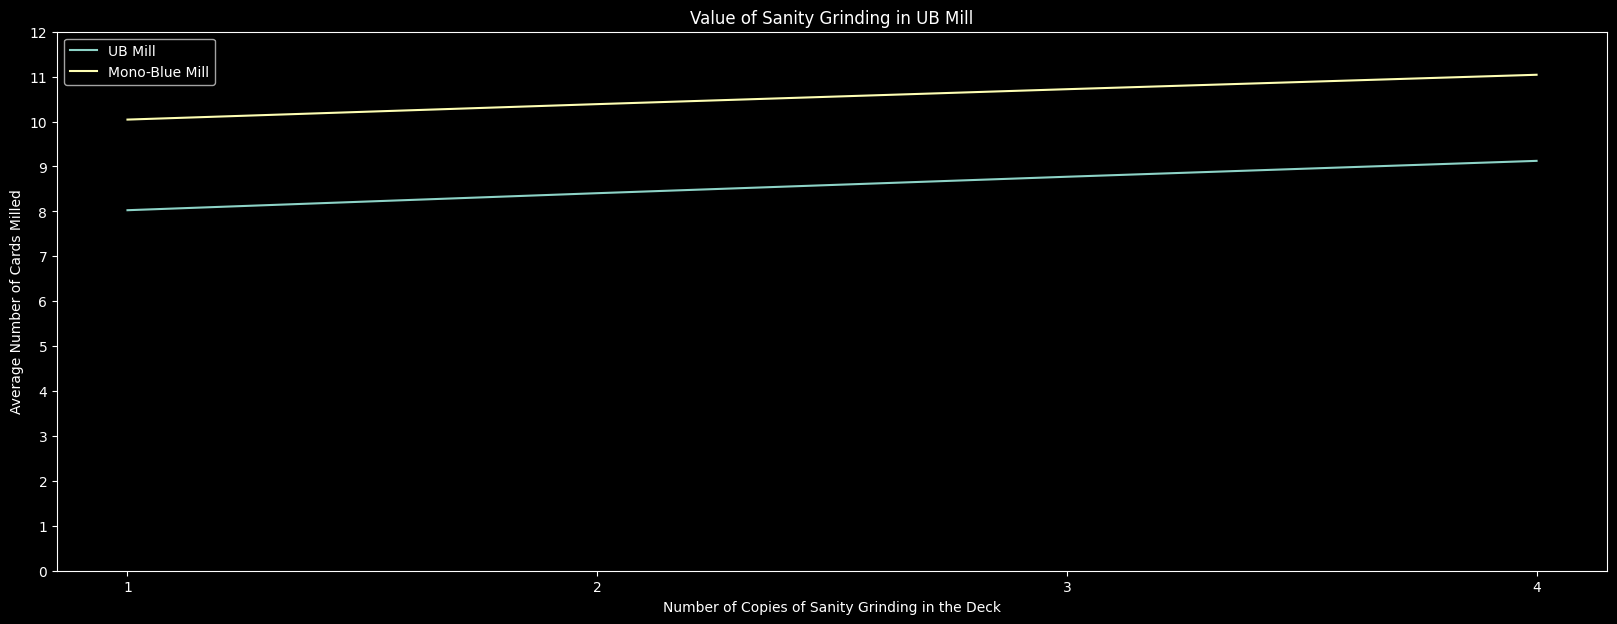

In [258]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)

ax.plot([i for i in range(1,5)], average_sg_value, label="UB Mill")
ax.plot([i for i in range(1,5)], average_sg_value_total, label="Mono-Blue Mill")

plt.title("Value of Sanity Grinding in UB Mill")

plt.xlabel("Number of Copies of Sanity Grinding in the Deck")
plt.ylabel("Average Number of Cards Milled")

plt.xticks([i for i in range(1,5)])
plt.yticks([i for i in range(0, 13)])

plt.legend()

plt.show()

## Conclusion

This card is simply not good for the mana cost. Tasha's Hideous Laughter mills more cards with the added benefit of exiling the removed cards while Fractured Sanity is generally going to mill more cards in most situations. Even if the deck were to be changed into a hypothetical one color (Blue) deck, this card would still underperform both of the other mentioned cards, while losing the beneficial cards that can be found in the second color.

# Mind Funeral

![Mind Funeral](http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=370509&type=card)

This card is not commonly played, and is largely viewed as a bad card. At the same price as Tasha's Hideous Laughter and Fractured Sanity but with no additional benefit beyond "mill the opponent", this card needs to outperform both of the aforementioned cards. This card mills until 4 land cards are found, which might be good against certain decks, but not every deck. Decks like "Amulet Titan" which can have over half of their deck be lands would be a poor use of this spell, but fewer lands in adeck can result in a better performance.

This is an easy calculation, and so it is worth looking at. I expect very little from this card, despite how fun it might be.

## Method

First, lands need to be separated from the non-lands. "Mind Funeral" mills based on the number of lands milled, requiring us to determine the likelihood of a land being milled on any particualr draw.

Second, once the likelhood of a draw being a land or not is determined, then we can determine this cards effectiveness.

Finally, a plot will be made to show the effectiveness of this card against the meta decks.

### Create a count of lands and nonlands for each deck

In [302]:
MindFuneralCount = pd.DataFrame(columns=['name', 'lands', 'non_lands'])
land_dict = {"Molten Collapse": 0, "Agatha's Soul Cauldron": 0, "Echoing Deeps": 1, 'Lůrien Revealed': 0, 'Confounding Riddle': 0, 'Troll of Khazad-dűm': 0, 
             'Sleep-Cursed Faerie': 0, 'Brackish Blunder': 0, 'Questing Druid': 0, 'Deeproot Pilgrimage': 0, 'Stalactite Stalker': 0, 'Souls of the Lost': 0, 
             'Amalia Benavides Aguirre': 0, 'Cenote Scout': 0, 'Inti, Seneschal of the Sun': 0, 'Bitter Triumph': 0, 'Spelunking': 0, 'Experimental Confectioner': 0, 
             'Get Lost': 0, 'Volatile Fault': 1, 'Sunken Citadel': 1, 'Not Dead After All': 0, "Tishana's Tidebinder": 0, 'L¾rien Revealed': 0}
missing_cards = []
alt_card = ""

for deck in deck_types:
    lands = 0
    non_lands = 0

    temp_df = MainboardMean.loc[deck]
    temp_df = temp_df[temp_df.astype(bool)].fillna(0)
    for card in list(temp_df.index):
        # Check local dictionary first to increase speed of process
        if card in list(land_dict.keys()):
            if land_dict[card] == 0:
                non_lands += temp_df.loc[card]
            elif land_dict[card] == 1:
                lands += temp_df.loc[card]
            else:
                print(card)
                raise ValueError(f"Wrong Value in land_dict: {land_dict[card]}")

            continue

        # Handle Alt-Cards
        if " / " in card:
            alt_card = card
            card = card.split(" / ")[0]

        # Check if present in database
        if len(CardsTypes[CardsTypes['name']==card].index) == 0:
            missing_cards.append(card)
            continue

        # Find in Card Database and save locally
        if CardsTypes[CardsTypes['name']==card]['Land'].iloc[0] > 0:
            if card in alt_card:
                lands += temp_df.loc[alt_card]
                land_dict[alt_card] = 1
            else:
                lands += temp_df.loc[card]
                land_dict[card] = 1
        else:
            if card in alt_card:
                non_lands += temp_df.loc[alt_card]
                land_dict[alt_card] = 0
            else:
                non_lands += temp_df.loc[card]
                land_dict[card] = 0

    MindFuneralCount.loc[len(MindFuneralCount.index)] = [deck, lands, non_lands]

print(set(missing_cards))

set()


In [303]:
MindFuneralCount['deck_size'] = MindFuneralCount[['lands', 'non_lands']].sum(axis=1)

### Calculate Percentages for each deck

In [305]:
MindFuneralCount.set_index('name', inplace=True)

In [308]:
MindFuneralCount[['land_percentage', 'non_land_percentage']] = MindFuneralCount[['lands', 'non_lands']].div(MindFuneralCount[['lands', 'non_lands']].sum(axis=1), axis=0)

In [548]:
"""
We are taking the probability of each permutation in which the nth land (4 for Mind Funeral) can be. By taking the overall permutations of the deck, and then finding the probability of each spot which
the nth land can be, we can add the probabilities to find the average cards pulled.
"""
def probability_of_n_reveals(land_count, non_land_count, n=4):
    if land_count == 0:
        return land_count + non_land_count

    deck_count = land_count + non_land_count
    unique_permutations = math.factorial(deck_count) / (math.factorial(land_count) * math.factorial(non_land_count))  # Gives unique number of permutations of deck
    total_permutations = 0
    max_location = deck_count - (land_count - n)  # Gives furthest location into deck that one might find a land card that would allow n to equal set value, while n = minimum location
    out = 0

    for i in range(0, (max_location - n + 1)):
        # n+1 is indicative of the position of the nth land
        # n is always going to be the land_count, beecause we are looking at unique permutations before it
        # i represents non_land_count, because it fills in the gaps for missing lands in the position tracked
        permutations_before = math.factorial(n + i - 1) / ((math.factorial(n - 1) * math.factorial(i))) # the number of permutations where the desired card is in location i
        permutations_after = math.factorial(deck_count - (n + i)) / ((math.factorial(land_count - n)) * math.factorial(non_land_count - i)) # the number of permutations following the desired card location
        permutations = permutations_before * permutations_after # The makeup of cards before and after will not change when calculating for a single spot, so we can multiply to find total permutations
        
        out += (n + i) * permutations / unique_permutations # Location of the nth card times the probability that it is there

    return out

In [551]:
MindFuneralCount["mind_funeral_average"] = MindFuneralCount.apply(lambda x: probability_of_n_reveals(round(x.lands), round(x.non_lands), 4), axis=1)

### Plot Findings

In [555]:
MindFuneralCount.sort_values("mind_funeral_average", ascending=True, inplace=True)

In [576]:
MindFuneralClear = MindFuneralCount.drop('Landless', axis=0)

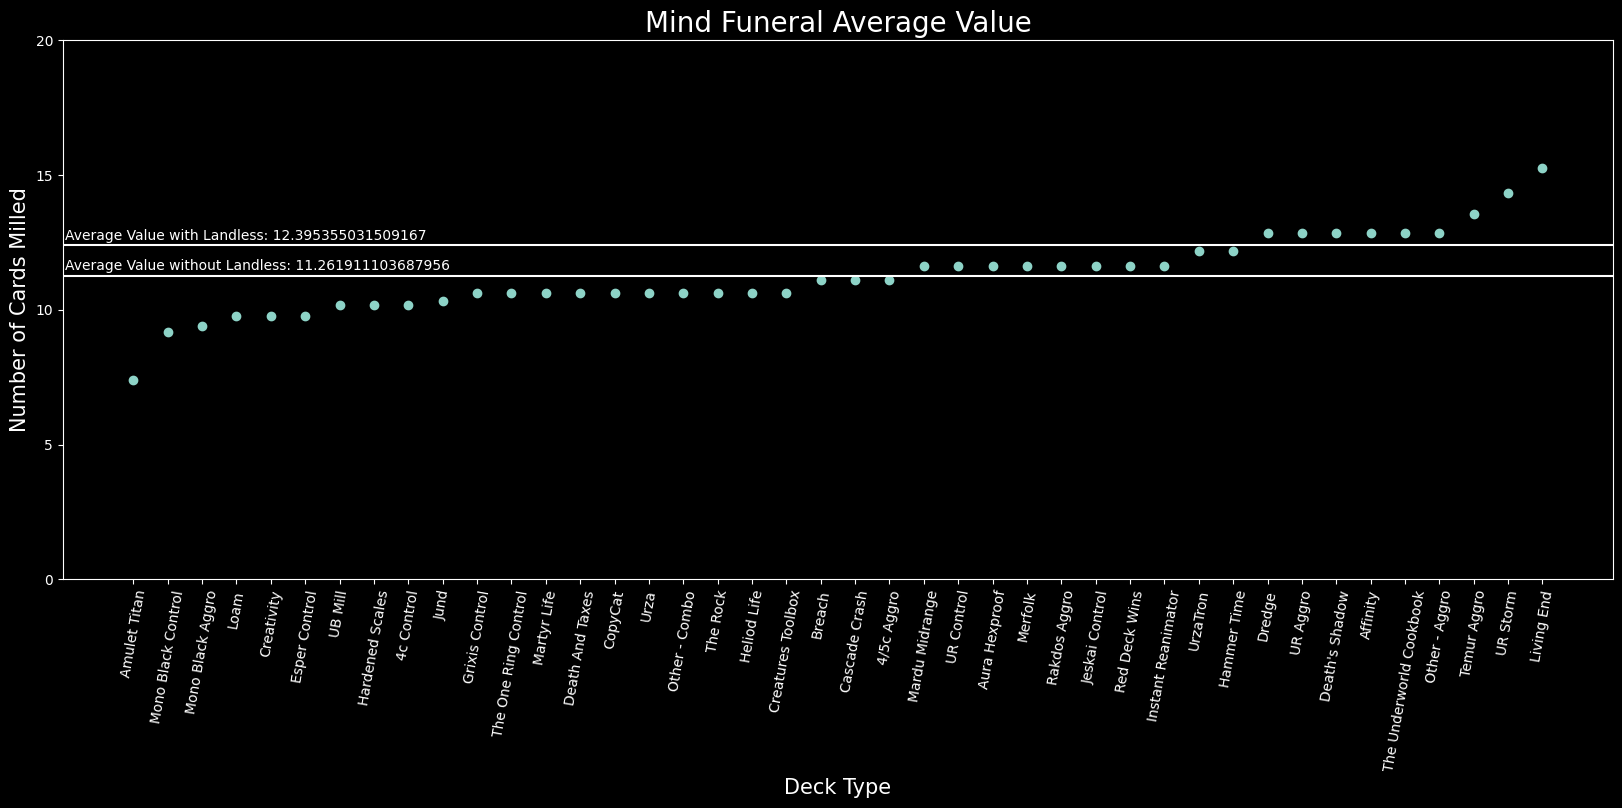

In [583]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111)

plt.title("Mind Funeral Average Value", fontsize=20)
plt.xlabel("Deck Type", fontsize=15)
plt.ylabel("Number of Cards Milled", fontsize=15)

ax.scatter(x = MindFuneralClear.index, y = MindFuneralClear["mind_funeral_average"])

plt.xticks(rotation=80)
plt.yticks([i for i in range(0, 25, 5)])

average_with_landless = MindFuneralCount["mind_funeral_average"].mean()
average_without_landless = MindFuneralCount.drop('Landless', axis=0)["mind_funeral_average"].mean()

plt.axhline(average_with_landless)
plt.text(x=-2, y=average_with_landless+0.2, s=f"Average Value with Landless: {average_with_landless}")

plt.axhline(average_without_landless)
plt.text(x=-2, y=average_without_landless+0.2 , s=f"Average Value without Landless: {average_without_landless}")

plt.show()


## Conclusions

The deck type "Landless", which holds a very small percentage of the metagame, was removed for the sake of clarity. The deck has no lands, and so Mind Funeral would automatically win the game. If you were to face this deck, this card is the best card you could possibly play, but I must admit that this card is better than I had originally thought it would be.

The biggest thing to note is how much more tightly packed this chart is compared to Tasha' Hideous Laughter, denoting a more even experience. The average value is also comparable to Tasha's Hideous Laughter after sideboarding, an instance when Mind Funeral would actually get better, because there is a smaller lands to non-land ratio, reducing the likelihood of a land being revealed.

I believe it is also worth noting that decks tend to run multiple ways to search for lands as a way to make their mana base more accessible for mulitple colors in the deck. As a result, this card would get better in the same instances that would make Tasha's Hideous Laughter worse. However, Tasha's is still slightly better in terms of cards milled, milling about two to three cards more on average and exiling the cards rather than putting them in the graveyard.

However, this does not mean that Tasha's Hideous Laughter is better in all instances. There are some decks, such as "Living End", where Mind Funeral is better and shoudl be considered when looking at a local meta. But Tasha's is generally going to be better overall and in more matchups. Tasha's held up against Fractured Sanity while Mind Funeral does not. In fact, Mind Funeral fits the same exact spot as Fractured Sanity, but it appears to be worse than that card.

Unfortunately, Mind Funeral appears to not be good enough for Modern Mill and provide enough utility to cover up its shortcomings.

# Hedron Crab / Ruin Crab Value over Time

<img src="http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=180348&type=card" alt="drawing" width="225"/>
<img src="http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=491705&type=card" alt="drawing" width="225"/>

These two creatures are highly prevalent and effective in mill, sometimes lending the name "8-Crab" to mill decks. Each time a land is played (only one land can be played per turn, unless another card would allow you to play more) by the crab's owner, the opponent mills three cards. Assuming no removal, each crab can mill three cards per turn. This might not seem like a lot when there are 60 cards in a deck, but this adds up over time and with multiple instances of crabs.

This ability is also benefitted by the use of "Fetch Lands" (lands which allow their owner search for other lands and put them on the battlefield) and the card "Field of Ruin" (when used, will allow each player to search for a absic land while destroying a non-basic land which that opponent controls). These cards can be used to trigger each crab to twice on that turn instead.

<img src="http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=405104&type=card" alt="drawing" width="225"/>
<img src="http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=535060&type=card" alt="drawing" width="225"/>

Assuming a land is played each turn, and the use of between 8 and 11 of these types of cards, what is the return value for these crabs?

## Method

# CMC per Mill Value